Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/tmp/ipython-input-335473722.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'])


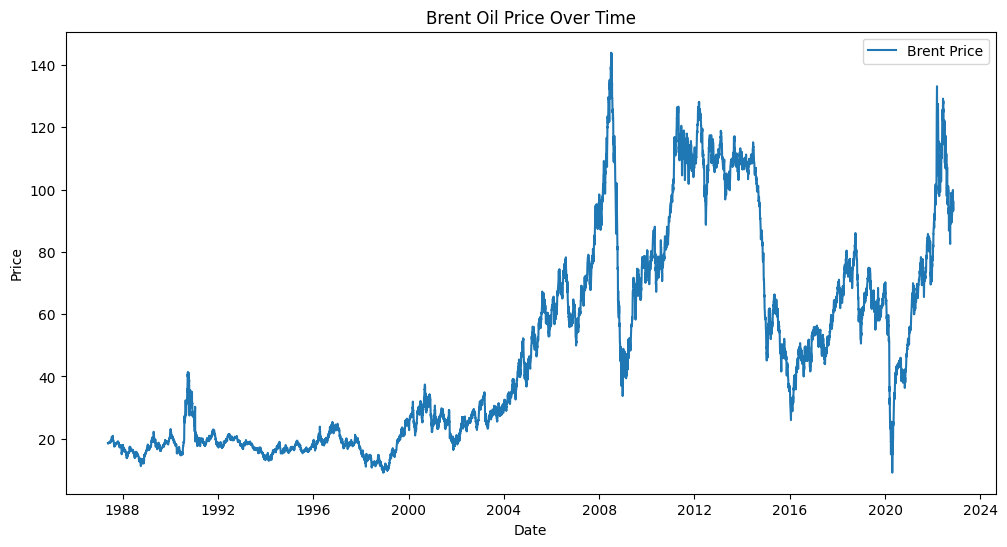

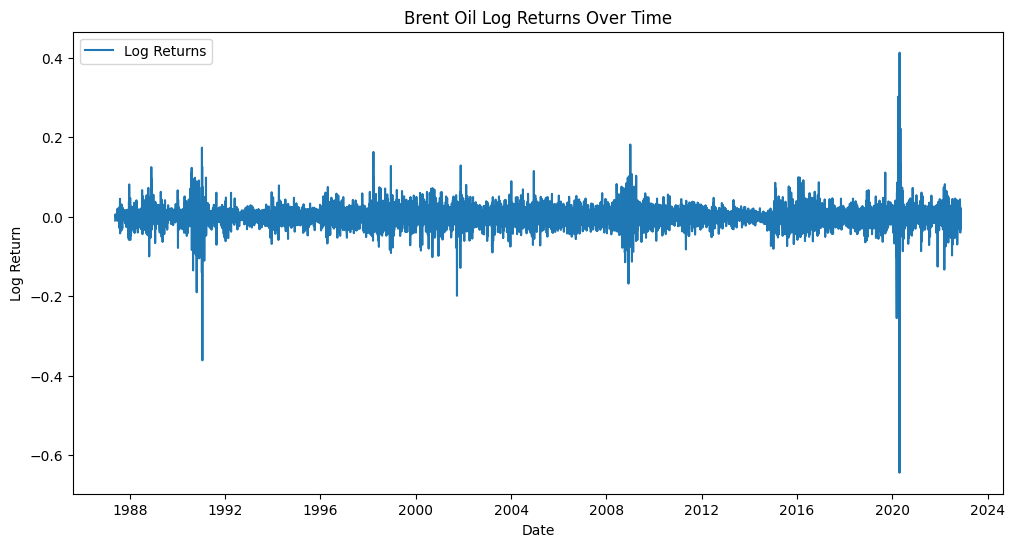

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load data
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/BrentOilPrices.csv')

# Convert 'Date' to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Sort by date if not sorted
df = df.sort_values('Date')

# Plot raw price series
plt.figure(figsize=(12,6))
plt.plot(df['Date'], df['Price'], label='Brent Price')
plt.title('Brent Oil Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Calculate log returns (log(price_t) - log(price_{t-1}))
df['LogReturn'] = np.log(df['Price']) - np.log(df['Price'].shift(1))

# Drop NaNs generated by shift()
df = df.dropna(subset=['LogReturn'])

# Plot log returns to observe volatility clustering
plt.figure(figsize=(12,6))
plt.plot(df['Date'], df['LogReturn'], label='Log Returns')
plt.title('Brent Oil Log Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.legend()
plt.show()


In [1]:
!pip install pymc

In [6]:
pip install pymc matplotlib numpy

In [7]:
import pymc as pm

In [8]:
import numpy as np
import matplotlib.pyplot as plt

In [9]:
np.random.seed(42)
n = 100
tau_true = 60
data = np.concatenate([
    np.random.normal(10, 1, tau_true),
    np.random.normal(15, 1, n - tau_true)
])

In [10]:
# Bayesian Change Point Model
with pm.Model() as model:
    tau = pm.DiscreteUniform('tau', lower=0, upper=n)

    mu_1 = pm.Normal('mu_1', mu=0, sigma=10)
    mu_2 = pm.Normal('mu_2', mu=0, sigma=10)

    sigma = pm.HalfNormal('sigma', sigma=10)

    mu = pm.math.switch(tau > np.arange(n), mu_1, mu_2)

    obs = pm.Normal('obs', mu=mu, sigma=sigma, observed=data)

    trace = pm.sample(1000, tune=1000, chains=2, random_seed=42)


Output()

/usr/local/lib/python3.11/dist-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


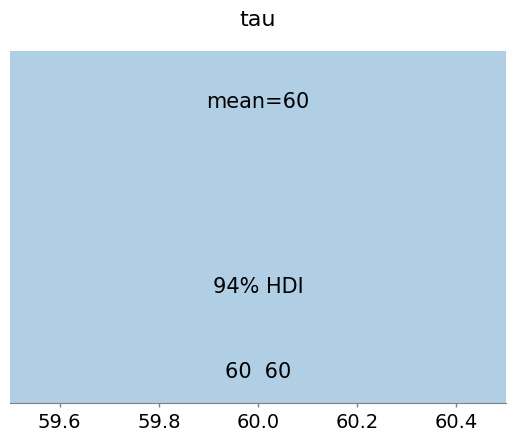

In [11]:
# Plot posterior of tau (switch point)
pm.plot_posterior(trace, var_names=['tau']);


Interpreting the Model Output:

Check for Convergence

In [12]:
# Summary statistics
pm.summary(trace, var_names=['tau', 'mu_1', 'mu_2', 'sigma'])


/usr/local/lib/python3.11/dist-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/usr/local/lib/python3.11/dist-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
tau,60.000,0.000,60.000,60.000,0.000,NaN,2000.0,2000.0,NaN
mu_1,9.847,0.121,9.630,10.080,0.002,0.002,3373.0,1608.0,1.0
mu_2,14.974,0.149,14.707,15.275,0.003,0.003,2871.0,1394.0,1.0
sigma,0.924,0.069,0.797,1.051,0.002,0.002,1946.0,1509.0,1.0


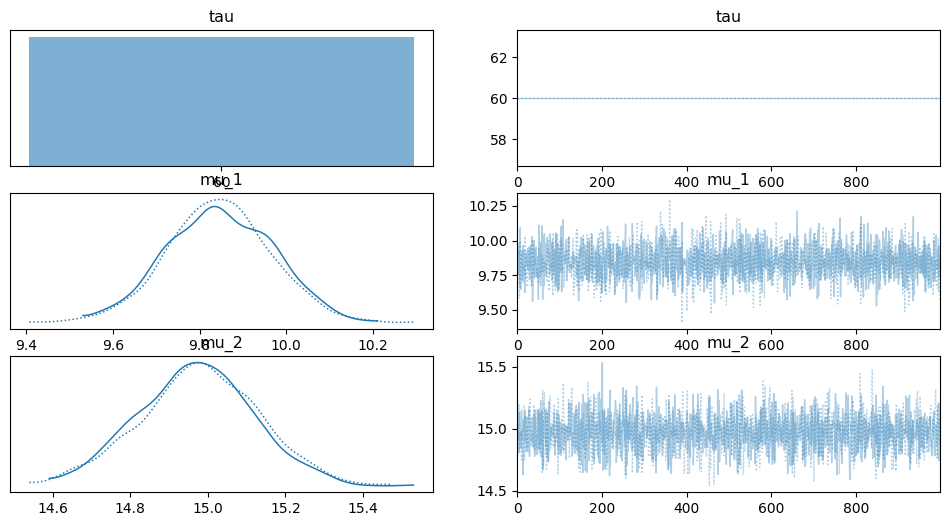

In [13]:
# Trace plots (should show good mixing and stable chains)
pm.plot_trace(trace, var_names=['tau', 'mu_1', 'mu_2']);


Identify the Change Point

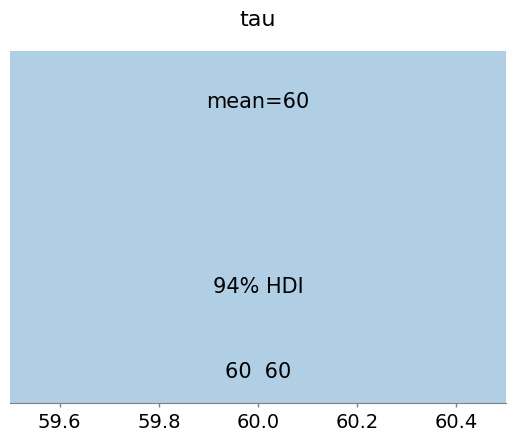

In [14]:
# Posterior distribution of switch point
pm.plot_posterior(trace, var_names=['tau']);


Quantify the Impact (Compare Before & After Means)

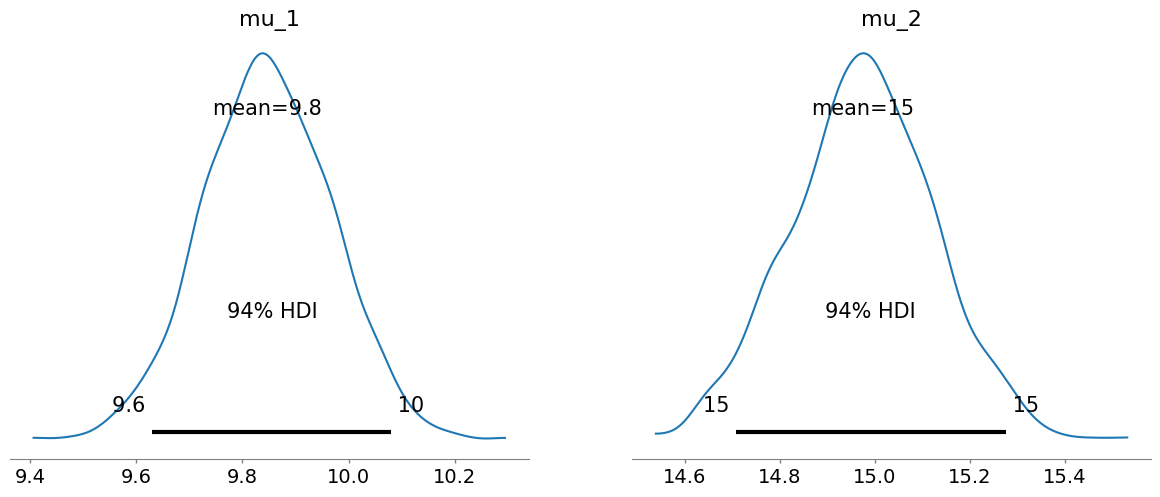

In [15]:
# Plot posteriors of mu_1 and mu_2
pm.plot_posterior(trace, var_names=['mu_1', 'mu_2']);


In [17]:
mu_1_samples = trace.posterior['mu_1'].values.flatten()
mu_2_samples = trace.posterior['mu_2'].values.flatten()
print(f"Probability mu_2 > mu_1: {(mu_2_samples > mu_1_samples).mean():.3f}")


Probability mu_2 > mu_1: 1.000
